In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

import torchvision
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
from torchinfo import summary
from collections import OrderedDict
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# The main architecture of the MobileNet V1

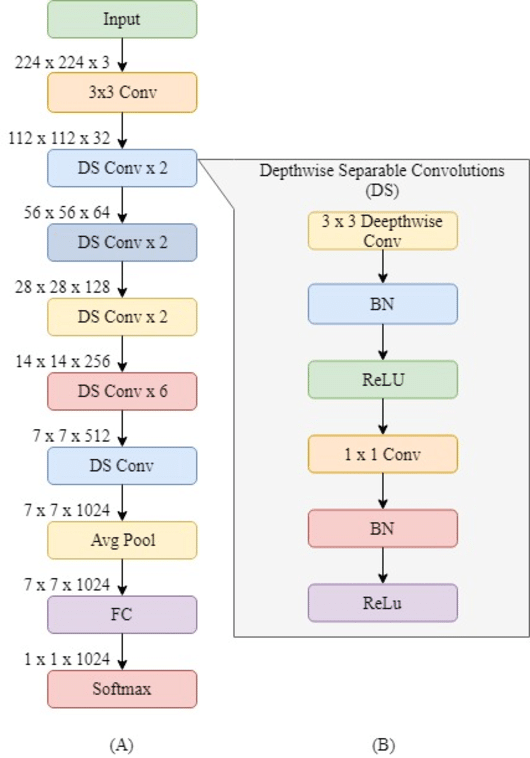

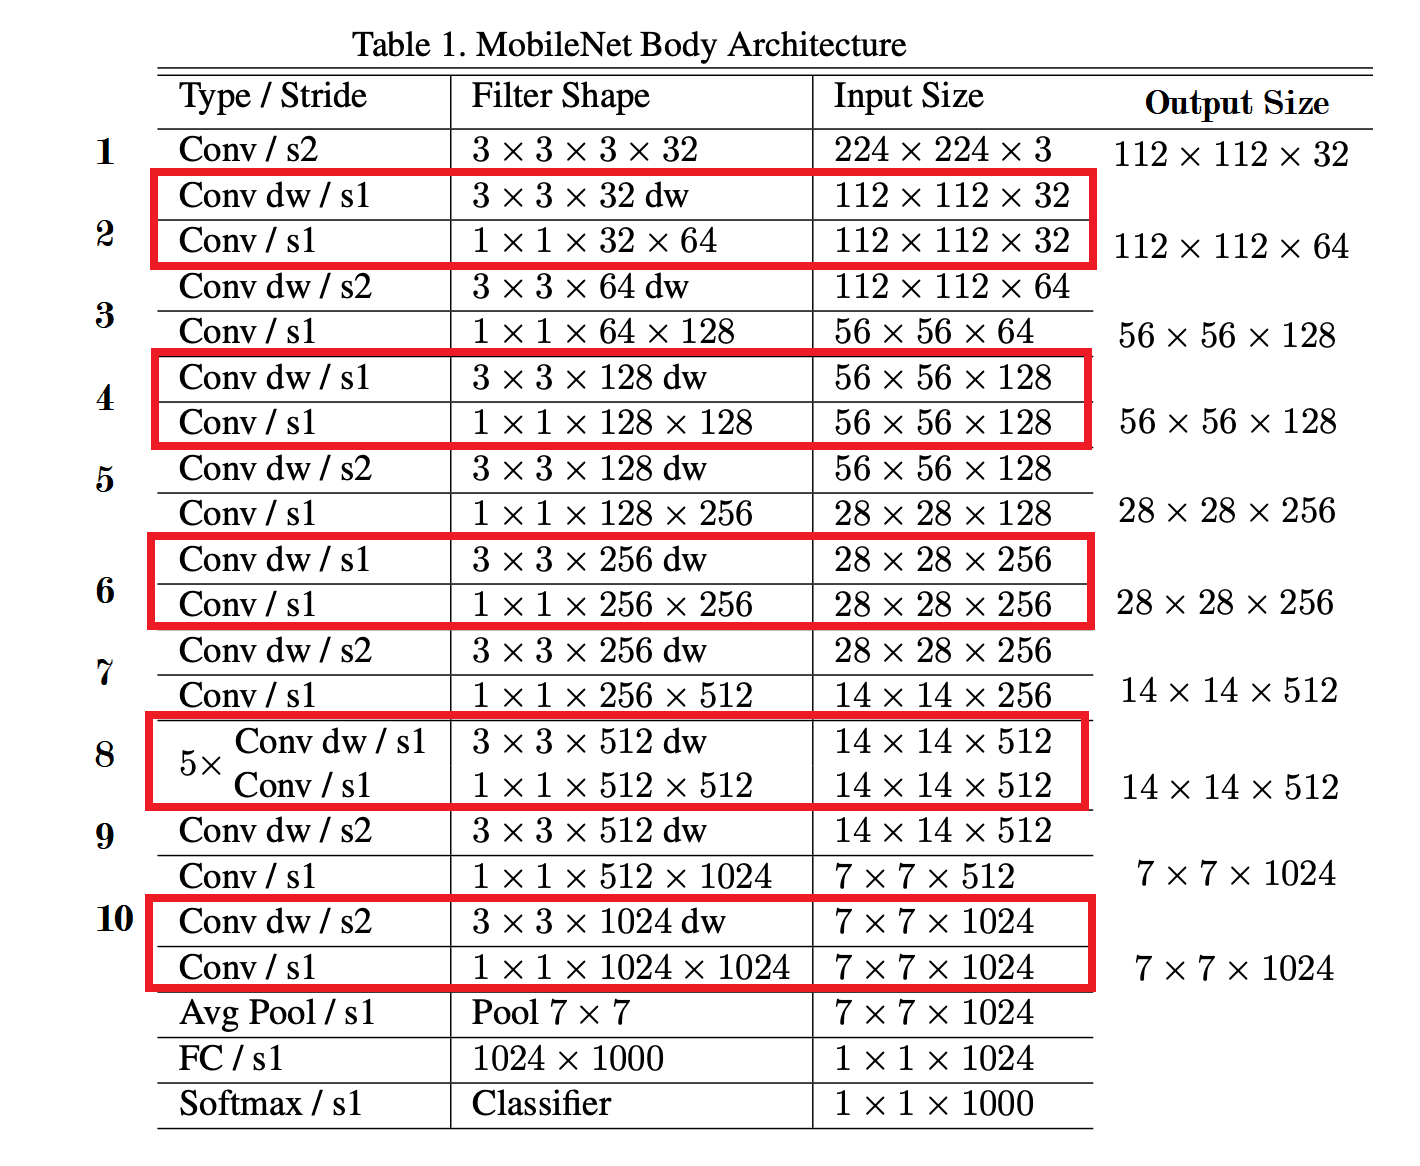

In [ ]:
# Calculate the output size of the convolutional layer

input=7
k=3
s=2
pad=4

# Calculate the output size of the convolutional layer
((input-k+2*pad)/s)+1

In [3]:
# Import the CIFAR-10 dataset

batch_size = 32

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:03<00:00, 48456362.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


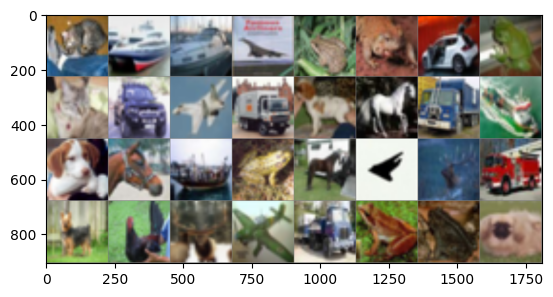

Ground Truth: cat ship ship airplane frog frog automobile frog cat automobile airplane truck dog horse truck ship


In [4]:
# Show some example images from the CIFAR-10 dataset
classes = train_dataset.classes

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images
images, labels = next(iter(test_loader))

# Show the images and their labels
imshow(torchvision.utils.make_grid(images))
print('Ground Truth:', ' '.join(classes[labels[j]] for j in range(16)))


# MobileNet V1 implementation

In [5]:
# Define the the main block of the model and its layers

class DepthwiseSeparableConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride, padding):

        super(DepthwiseSeparableConv, self).__init__()
        
        self.DWConv_BN_Act_PWConv_BN_Act = nn.Sequential(

            nn.Conv2d(in_channels, in_channels, kernel_size=3, bias=False,stride=stride, padding=padding, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)

        )

    def forward(self, x):
        return self.DWConv_BN_Act_PWConv_BN_Act(x)


# Define the model structure

class MobileNetV1(nn.Module):
    def __init__(self, num_classes ,dropout = 0.1):
        super(MobileNetV1, self).__init__()


        #----------
        self.conv_1 =  nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        
        # -----------
        self.conv_2 =  nn.Sequential(
            DepthwiseSeparableConv(in_channels=32, out_channels=64, stride=1, padding=1),
        )


        # ----------
        self.conv_3 =  nn.Sequential(
            DepthwiseSeparableConv(in_channels=64, out_channels=128, stride=2, padding=1),
        )


        # -----------
        self.conv_4 =  nn.Sequential(
            DepthwiseSeparableConv(in_channels=128, out_channels=128, stride=1, padding=1),
        )


        # -----------
        self.conv_5 =  nn.Sequential(
            DepthwiseSeparableConv(in_channels=128, out_channels=256, stride=2, padding=1),
        )
        

        # -----------
        self.conv_6 =  nn.Sequential(
            DepthwiseSeparableConv(in_channels=256, out_channels=256, stride=1, padding=1),
        )


        # -----------
        self.conv_7 =  nn.Sequential(
            DepthwiseSeparableConv(in_channels=256, out_channels=512, stride=2, padding=1),
        )


        # -----------
        self.conv_8 = nn.Sequential(
            DepthwiseSeparableConv(in_channels=512, out_channels=512, stride=1, padding=1),
            DepthwiseSeparableConv(in_channels=512, out_channels=512, stride=1, padding=1),
            DepthwiseSeparableConv(in_channels=512, out_channels=512, stride=1, padding=1),
            DepthwiseSeparableConv(in_channels=512, out_channels=512, stride=1, padding=1),
            DepthwiseSeparableConv(in_channels=512, out_channels=512, stride=1, padding=1)
        )


        # -----------
        self.conv_9 = nn.Sequential(
            DepthwiseSeparableConv(in_channels=512, out_channels=1024, stride=2, padding=1),
        )


        # -----------
        self.conv_10 = nn.Sequential(
            DepthwiseSeparableConv(in_channels=1024, out_channels=1024, stride=2, padding=4),
        )


        #--------
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Flatten(1),
            nn.Dropout(dropout),
            nn.Linear(1024, num_classes)
        )


    def forward(self, x):
        
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.conv_6(x)
        x = self.conv_7(x)
        x = self.conv_8(x)
        x = self.conv_9(x)
        x = self.conv_10(x)
        x = self.avg_pool(x)
        x = self.fc(x)

        return x


     
# Define the input size
# Summary of the model

model = MobileNetV1(1000 , 0).to(device)
input_size = (1,3, 224, 224)
summary(model, input_size=input_size ,depth = 1 ,row_settings=["var_names"] )


Layer (type (var_name))                                      Output Shape              Param #
MobileNetV1 (MobileNetV1)                                    [1, 1000]                 --
├─Sequential (conv_1)                                        [1, 32, 112, 112]         928
├─Sequential (conv_2)                                        [1, 64, 112, 112]         2,528
├─Sequential (conv_3)                                        [1, 128, 56, 56]          9,152
├─Sequential (conv_4)                                        [1, 128, 56, 56]          18,048
├─Sequential (conv_5)                                        [1, 256, 28, 28]          34,688
├─Sequential (conv_6)                                        [1, 256, 28, 28]          68,864
├─Sequential (conv_7)                                        [1, 512, 14, 14]          134,912
├─Sequential (conv_8)                                        [1, 512, 14, 14]          1,344,000
├─Sequential (conv_9)                                        [1,

In [6]:
# Create an instance of the mobilnetv1 model
model = MobileNetV1(10 , 0).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Define the input size
input_size = (1,3, 224, 224)
summary(model, input_size=input_size ,depth = 1 ,row_settings=["var_names"] )


Layer (type (var_name))                                      Output Shape              Param #
MobileNetV1 (MobileNetV1)                                    [1, 10]                   --
├─Sequential (conv_1)                                        [1, 32, 112, 112]         928
├─Sequential (conv_2)                                        [1, 64, 112, 112]         2,528
├─Sequential (conv_3)                                        [1, 128, 56, 56]          9,152
├─Sequential (conv_4)                                        [1, 128, 56, 56]          18,048
├─Sequential (conv_5)                                        [1, 256, 28, 28]          34,688
├─Sequential (conv_6)                                        [1, 256, 28, 28]          68,864
├─Sequential (conv_7)                                        [1, 512, 14, 14]          134,912
├─Sequential (conv_8)                                        [1, 512, 14, 14]          1,344,000
├─Sequential (conv_9)                                        [1,

Epoch 1/10:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 1/10 - Train Loss: 1.3187 - Train Accuracy: 51.94% - Test Loss: 1.1654 - Test Accuracy: 60.47%


Epoch 2/10:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 2/10 - Train Loss: 0.8628 - Train Accuracy: 69.72% - Test Loss: 0.7778 - Test Accuracy: 73.52%


Epoch 3/10:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 3/10 - Train Loss: 0.6390 - Train Accuracy: 77.68% - Test Loss: 0.6178 - Test Accuracy: 78.50%


Epoch 4/10:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 4/10 - Train Loss: 0.5104 - Train Accuracy: 82.36% - Test Loss: 0.5489 - Test Accuracy: 81.15%


Epoch 5/10:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 5/10 - Train Loss: 0.4122 - Train Accuracy: 85.63% - Test Loss: 0.4936 - Test Accuracy: 83.54%


Epoch 6/10:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 6/10 - Train Loss: 0.3327 - Train Accuracy: 88.28% - Test Loss: 0.5030 - Test Accuracy: 83.47%


Epoch 7/10:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 7/10 - Train Loss: 0.2706 - Train Accuracy: 90.53% - Test Loss: 0.5528 - Test Accuracy: 82.73%


Epoch 8/10:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 8/10 - Train Loss: 0.2191 - Train Accuracy: 92.32% - Test Loss: 0.5314 - Test Accuracy: 83.52%


Epoch 9/10:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 9/10 - Train Loss: 0.1773 - Train Accuracy: 93.87% - Test Loss: 0.5485 - Test Accuracy: 83.85%


Epoch 10/10:   0%|          | 0/1563 [00:00<?, ?batch/s]

Epoch 10/10 - Train Loss: 0.1566 - Train Accuracy: 94.53% - Test Loss: 0.5298 - Test Accuracy: 84.36%


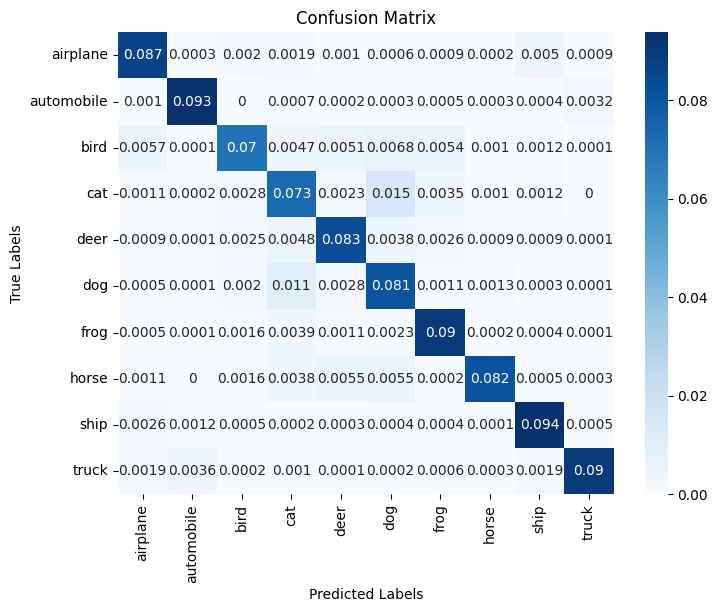

In [7]:
# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
       
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # Update the progress bar
        pbar.update(1)
        pbar.set_postfix({'Loss': loss.item()})
         
    # Close the progress bar
    pbar.close()
    
    train_loss /= len(train_loader)
    train_accuracy = 100.0 * correct / total
#------------------------------------------------------------------------------    
    # Validation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predicted = []
    
    all_labels = []
   
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_predicted.append(predicted)
            all_labels.append(labels)
            
            
    
    # Convert the lists to tensors
    all_predicted = torch.cat(all_predicted).tolist()
    all_labels = torch.cat(all_labels).tolist()
    
    test_loss /= len(test_loader)
    test_accuracy = 100.0 * correct / total
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predicted ,normalize= 'all')
    
    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}% - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")
    


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

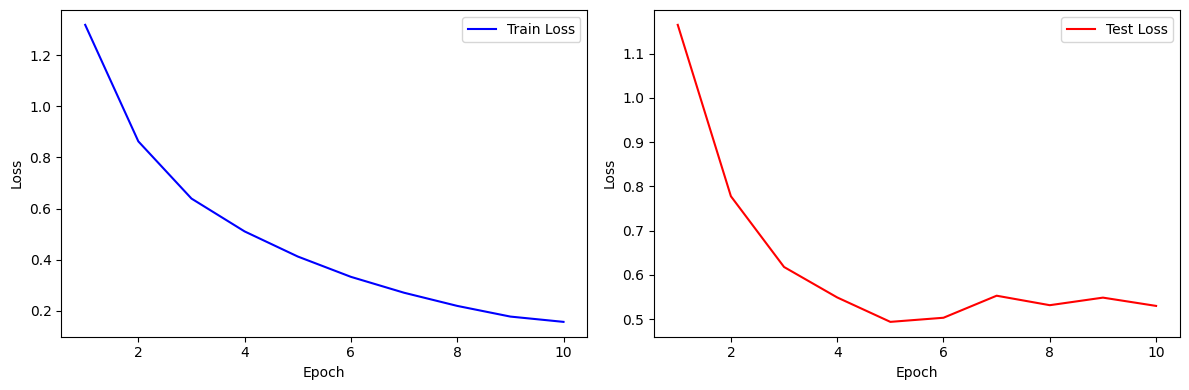

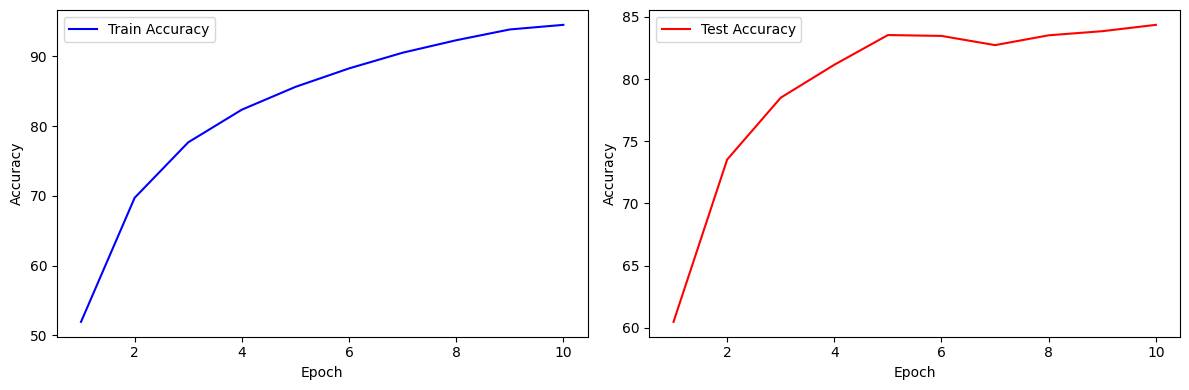

In [8]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot(epochs, test_losses, 'r-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

# Plot train accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()